# HNN EU Data

In [7]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable
#from torchsummary import summary
#import torch.utils.data as Data

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import scale
from statsmodels.tsa.stattools import adfuller

import copy
import itertools
import os
import time
import random
import math
import warnings
import sys

warnings.filterwarnings("ignore")

sys.path.append('../src/data/')

# Import HNN and tools functions
from HNN import HNN
import TrainHNN as TrainHNN
import DataProcessing as DataTools

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pd.set_option('display.max_columns', 2000) 

In [8]:
inflation = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='1.Inflation')
activity = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='2.Real activity')
external = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='3.External')
expectations = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='5.Expectations')
inflation

,HICPxEN_SA,HICPxENFOOD_SA
NaT,NaN,NaN
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
...,...,...
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170
2017-12-31,118.95130,116.36400


In [9]:
inflation = inflation.iloc[1:-1,:]
activity = activity.iloc[1:-1,:]
external = external.iloc[1:-1,:]
expectations = expectations.iloc[1:-1,:]
inflation

,HICPxEN_SA,HICPxENFOOD_SA
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
2000-03-31,89.88590,90.99102
...,...,...
2016-12-31,117.52750,115.29530
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170


In [10]:
# take the 1st difference
activity = activity.diff()
external = external.diff()
expectations = expectations.diff()
expectations

,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208,0.106208,-0.069844,0.027941,0.061274,-0.014597,-0.051618,0.133385,0.110731,0.122038,-2.205786


In [11]:
inflation['Log_CPI'] = np.log(inflation['HICPxEN_SA'])

inflation['y'] = inflation['Log_CPI'].diff()

inflation

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y
1999-03-31,89.14290,90.10781,4.490241,NaN
1999-06-30,89.26107,90.24440,4.491565,0.001325
1999-09-30,89.45457,90.60880,4.493731,0.002165
1999-12-31,89.67210,90.66729,4.496160,0.002429
2000-03-31,89.88590,90.99102,4.498541,0.002381
...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216
2017-03-31,117.96370,115.54440,4.770377,0.003705
2017-06-30,118.33870,116.00980,4.773551,0.003174
2017-09-30,118.70470,116.36170,4.776639,0.003088


In [13]:
data = pd.concat([inflation, activity, external, expectations], axis=1, join='inner')
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-03-31,89.14290,90.10781,4.490241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4.333281,-3.410087,3.729492,-0.382453,4.170970,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208

In [14]:
# remove 1st row
data = data.iloc[1:,:]
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4

In [15]:
# rename index to date and make it a column
data = data.reset_index()
# rename index to date and make it the first column
data = data.rename(columns={'index':'date'})
data

,date,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
0,1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1,1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
2,1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
3,2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
4,2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
71,2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
72,2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
73,2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100

In [16]:
# rename HICPxEN_SA to y
# data = data.rename(columns={'HICPxEN_SA':'y'})
# drop HICPxENFOOD_SA
data = data.drop(columns=['HICPxENFOOD_SA', 'HICPxEN_SA', 'Log_CPI'])
data

,date,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
2,1999-12-31,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
3,2000-03-31,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
4,2000-06-30,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
71,2017-03-31,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
72,2017-06-30,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
73,2017-09-30,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4.333281,-3.410087,3.729492,-0.382453,4.170970,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208,0.106208,-0.069844,0.027941,0.061274,-0.014597,-0.051618,0.133385,0.110731,0.122038,-2.205786


In [17]:
def create_lagged_columns_v2(df, num_lags):
    """
    Create specified number of lagged columns for each variable in the DataFrame.
    For the variable named 'y', do not add 'L0_' prefix and use a different naming convention for lags.

    Parameters:
    df (pd.DataFrame): The original DataFrame with macroeconomic data.
    num_lags (int): The number of lagged columns to create.

    Returns:
    pd.DataFrame: A DataFrame with the original and lagged columns.
    """

    lagged_data_chunks = []

    for col in df.columns:
        if col != 'date':
            # For the 'y' variable, handle lag creation and naming differently
            if col == 'y':
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[col].shift(lag).rename(f"L_{lag - 1}y"))
            else:
                # Rename the macroeconomic variables with "L0_" and create lagged columns
                df = df.rename(columns={col: f"L0_{col}"})
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[f"L0_{col}"].shift(lag).rename(f"L{lag}_{col}"))

    df_final = pd.concat([df] + lagged_data_chunks, axis=1)

    return df_final

In [18]:
data1 = create_lagged_columns_v2(data, 3)
data1

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.001325,NaN,NaN,13595.663503,NaN,NaN,-0.13,NaN,NaN,0.12413,NaN,NaN,-0.102900,NaN,NaN,0.363011,NaN,NaN,0.389807,NaN,NaN,0.0,NaN,NaN,0.586015,NaN,NaN,0.34650,NaN,NaN,0.5036,NaN,NaN,-0.027100,NaN,NaN,-0.162720,NaN,NaN,-0.064702,NaN,

In [19]:
def calculate_selected_marx(data):
    """
    Calculate L1_MARX and L3_MARX values for the first lagged column of each macroeconomic variable in the dataset.

    :param data: DataFrame containing the data with lagged variables.
    :return: DataFrame with calculated L1_MARX and L3_MARX values for each variable.
    """
    result = data.copy()

    # Extracting unique variable names from L0_ columns
    variable_names = [col.split('_', 1)[1] for col in data.columns if col.startswith('L0_')]

    for var in variable_names:
        result[f'L1_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}']].mean(axis=1)
        result[f'L3_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}', f'L2_{var}', f'L3_{var}']].mean(axis=1)

    return result

In [20]:
data2 = calculate_selected_marx(data1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [21]:
# remove the first 3 rows
data2 = data2.iloc[3:,:]
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [22]:
# replace nan with 0
data2 = data2.fillna(0)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [23]:
data2['trend'] = range(1, len(data2) + 1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_Eurob,L1_MARX_SPF_Cons_Bloom,L3_MARX_SPF_Cons_Bloom,L1_MARX_SPF_Eurob_Bloom,L3_MARX_SPF_Eurob_Bloom,L1_MARX_Cons_Euro_Blo

In [24]:
# data2.to_csv('../data/processed/dataEU.csv', index=False)

In [25]:
# dates vector
dates = data2.iloc[:, 0]
dates = dates.astype(str)
data2 = data2.iloc[:, 1:]

# get column names
col_names = list(data2.columns)[1:]

In [26]:
oos_pos = dates[dates == "2015-03-31"].index[0] # OOS start position
oos_pos

63

In [27]:
X_train, X_test, y_train, y_test, y_mean, y_std = DataTools.preprocess_data(data2, split_id = oos_pos, scale_y = True, scale_x = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([63, 274]),
 torch.Size([63]),
 torch.Size([9, 274]),
 torch.Size([9]))

## Adding the New Hemisphere

In [28]:
# Which lags to use ? (all the first part of the column name in the data)
first_part = ["L0_", "L1_", "L2_", "L3_","L1_MARX_", "L3_MARX_"]

# Hemisphere 1 : Real activity
labor_name = ['RealGDP', 'UR', 'OutputGap', 'UnemplGap', 'AVGDGP', 'AVGDGT',
       'RecessionGap', 'ULCindx', 'IMFWEOgap', 'ECBJLgap', 'NAIRU', 'U6']
hemisphere_var = DataTools.append_list(first_part, labor_name)
x_pos1 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos1)

# Hemisphere 2 : Short-run expectations
price_name = ['SPF_2Y', 'SPF_1Y', 'Consensus_1Q', 'Consensus_2Q', 'Consensus_3Q',
       'Consensus_1Y', 'Eurobarometer_1Q', 'Eurobarometer_2Q',
       'Eurobarometer_3Q', 'Eurobarometer_1Y', 'BLOOMBERG_1Y1Y', 'SPF_Cons',
       'SPF_Eurob', 'SPF_Bloom', 'Cons_Eurob', 'Cons_Bloom', 'Eurob_Bloom',
       'SPF_Cons_Eurob', 'SPF_Cons_Bloom', 'SPF_Eurob_Bloom',
       'Cons_Euro_Bloom', 'SPF_Cons_Eurob_Bloom', 'ECBILS1Y', 'ECBILS1Y1Y',
       'ECBILS2Y', 'ConsumerEC']
hemisphere_var = DataTools.append_list(first_part, price_name)
x_pos2 = DataTools.find_position(col_names, hemisphere_var)
x_pos2 = list(range(0,4)) + x_pos2
#print(x_pos2)

# Hemisphere 3 : Commodities
commodities_name = ['EUR_USD', 'OILSDW', 'NEER', 'NonenComEUR', 'DG_AGRI', 'SDWimpdef',
       'NonEnComUSD']
hemisphere_var = DataTools.append_list(first_part, commodities_name)
x_pos3 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos3)

# Hemisphere 4 : Long-run expectations
x_pos4 = [(X_train.shape[1]-1)] # trend position
#print(x_pos4)

# Put all hemisphere position together
x_pos = [x_pos1, x_pos2, x_pos3 , x_pos4, x_pos4, x_pos4, x_pos4] # the last 3 x_pos4 are for the coefficients associated with each hemisphere

In [29]:
# Nodes in each layers
nodes = []
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 1
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 2
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 3
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 4
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 1
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 2
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 3

# Number of inputs
n_features = [len(x_pos1), len(x_pos2), len(x_pos3), 1, 1, 1, 1] # hemisphere 1, 2, 3, 4, trend 1, trend 2, trend 3

# Add a trend to the hemispheres
add_trends_to = list(range(0,3))

# Hyperparameters list
nn_hyps = {"nodes":nodes,                   # Number of neurons and hidden layers      
           "n_features":n_features,         # Number of inputs in each hemisphere
           "dropout_rate":0.2,              # Dropout rate in each layers (same for all hemispheres)
           "add_trends_to":add_trends_to,   # Add trend (time varying coefficient) to hemispheres 1 to 3
           "x_pos":x_pos,                   # Position of the variables in each hemisphere
           "lr":0.05,                       # Learning rate
           "epochs":500,                    # Maximum number of epochs
           "patience":50,                   # Number of epochs before stopping once your loss starts to increase (Return the best model)
           "block_size":6,                  # Number of quarter the use in block bootstrap (not used if opt_bootstrap = 1)          
           "num_bootstrap":300,             # Number of bootstrap
           "opt_bootstrap":2,               # Bootstrapping types (1: Normal, 2: block bootstrap)
           "model_to_return":'last',        # Return the last model ("last") or the best model ("best") after the early stopping
           "sampling_rate":0.85,            # In-sample sampling rate
           "tol":0.01,                      # Early stopping criteria tolerance (MSE)
           "always_oob": None,              # Rows to always include in OOB ("None", to not use "always_oob" ; otherwise list(range(ao_start, ao_end+1)))
           "device":device,
           "seed":1234}

In [30]:
results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

Bootstrap 0
Early stopped on epoch 99
Best epoch: 48

Bootstrap 1
Early stopped on epoch 89
Best epoch: 38

Bootstrap 2
Early stopped on epoch 160
Best epoch: 158

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 57
Best epoch: 6

Bootstrap 5
Early stopped on epoch 158
Best epoch: 147

Bootstrap 6
Early stopped on epoch 84
Best epoch: 33

Bootstrap 7
Early stopped on epoch 88
Best epoch: 37

Bootstrap 8
Early stopped on epoch 118
Best epoch: 104

Bootstrap 9
Early stopped on epoch 62
Best epoch: 16

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 93
Best epoch: 42

Bootstrap 12
Early stopped on epoch 198
Best epoch: 174

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 54
Best epoch: 3

Bootstrap 15
Early stopped on epoch 114
Best epoch: 97

Bootstrap 16
Early stopped on epoch 121
Best epoch: 98

Bootstrap 17
Early stopped on epoch 79
Best epoch: 28

Bootstrap 18
Ea

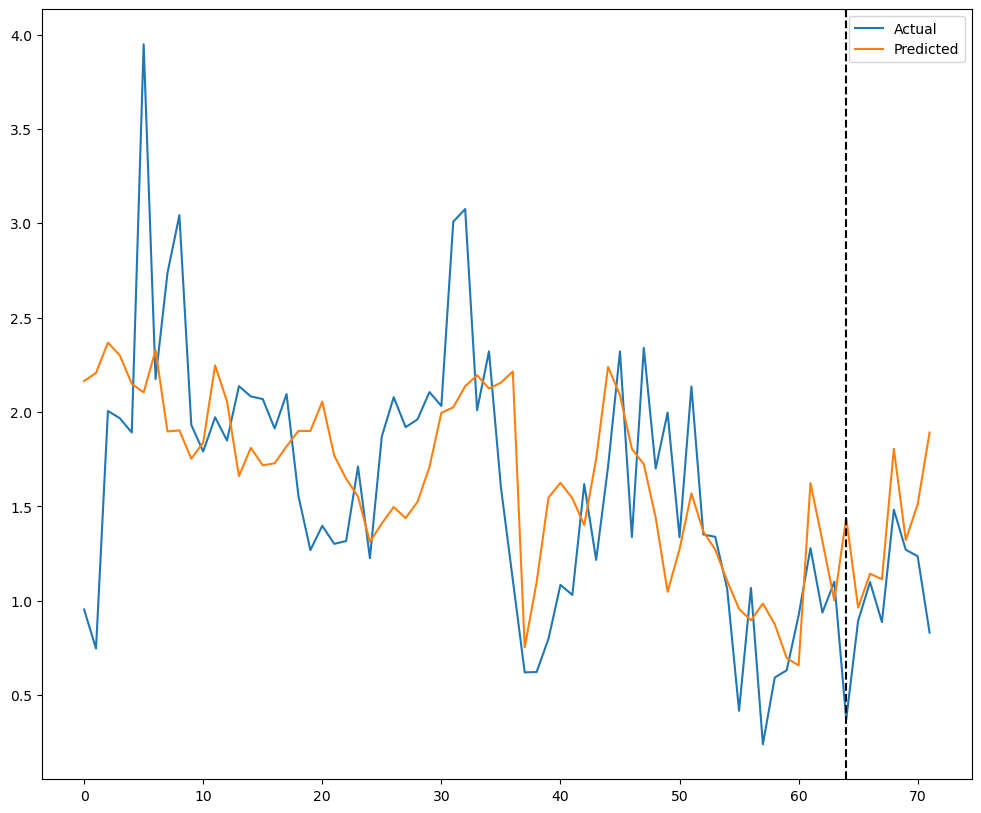

In [31]:
pred_in = results["pred_in_mean"] # In-sample (train)
pred_out = results["pred_mean"]   # OOS (test)

# Annualized in-sample
predict = np.concatenate((pred_in, pred_out), axis=0)
predict = DataTools.inverse_scaling(predict, y_mean, y_std) * 400

# Annualized OOS
real = np.concatenate((y_train, y_test), axis=0)
real = DataTools.inverse_scaling(real, y_mean, y_std) * 400

# Plot the results
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(real, label='Actual')
plt.plot(predict, label='Predicted')
plt.axvline(x=(oos_pos+1), color='black', linestyle='--')
plt.legend()
plt.show()

OOS RMSE : 0.41689186758368535


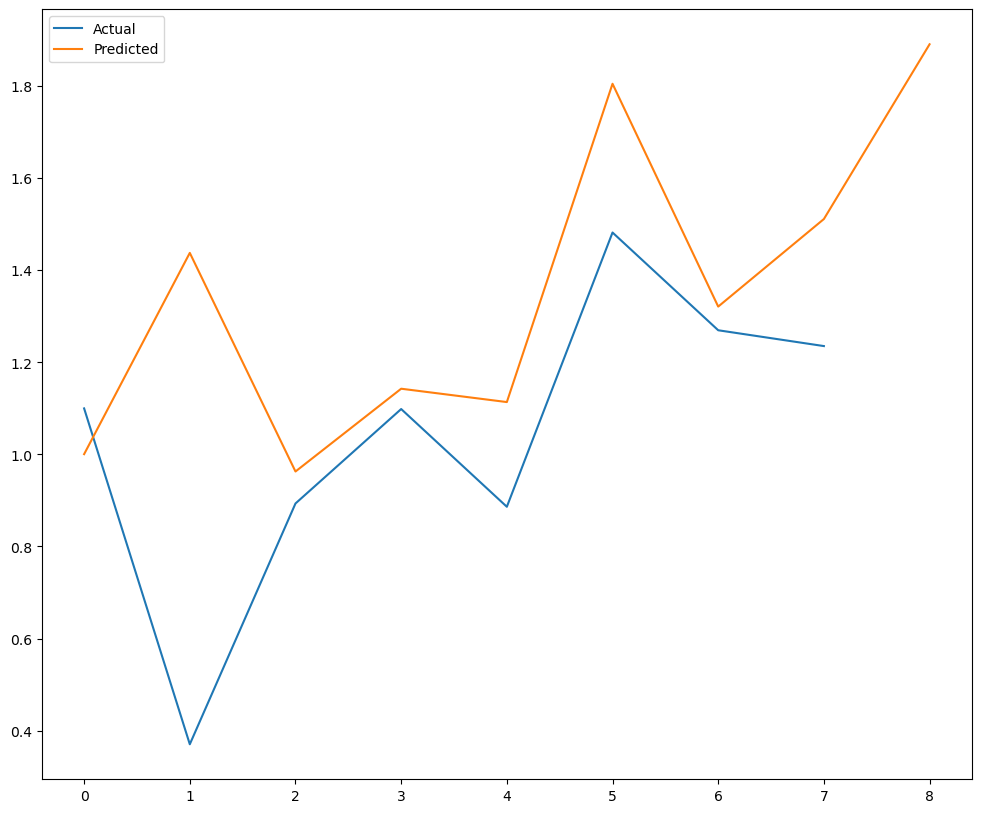

          Date  Realized  HNN1
66  2015-12-31       1.1   1.0
67  2016-03-31       0.4   1.4
68  2016-06-30       0.9   1.0
69  2016-09-30       1.1   1.1
70  2016-12-31       0.9   1.1
71  2017-03-31       1.5   1.8
72  2017-06-30       1.3   1.3
73  2017-09-30       1.2   1.5
74  2017-12-31       NaN   1.9


In [33]:
# Realized values
realized = y_test[:-1] # Remove the last value (2018Q1)
realized = np.append(realized, np.nan)
realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

# Forecasted values
predicted = results["pred_mean"]
predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

# Plot the results
print("OOS RMSE : " + str(math.sqrt(DataTools.MSE(realized, predicted)))) # RMSE
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(realized, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Put realized and predicted values in a dataframe
df = pd.DataFrame({'Date':dates[-len(realized):],
                   'Realized': realized,
                   'HNN1': predicted})
df = df.round(1)
print(df)

In [34]:
df

,Date,Realized,HNN1
66,2015-12-31,1.1,1.0
67,2016-03-31,0.4,1.4
68,2016-06-30,0.9,1.0
69,2016-09-30,1.1,1.1
70,2016-12-31,0.9,1.1
71,2017-03-31,1.5,1.8
72,2017-06-30,1.3,1.3
73,2017-09-30,1.2,1.5
74,2017-12-31,NaN,1.9


In [35]:
df.to_csv('../data/predictions/HNN1.csv', index=False)

## Contributions

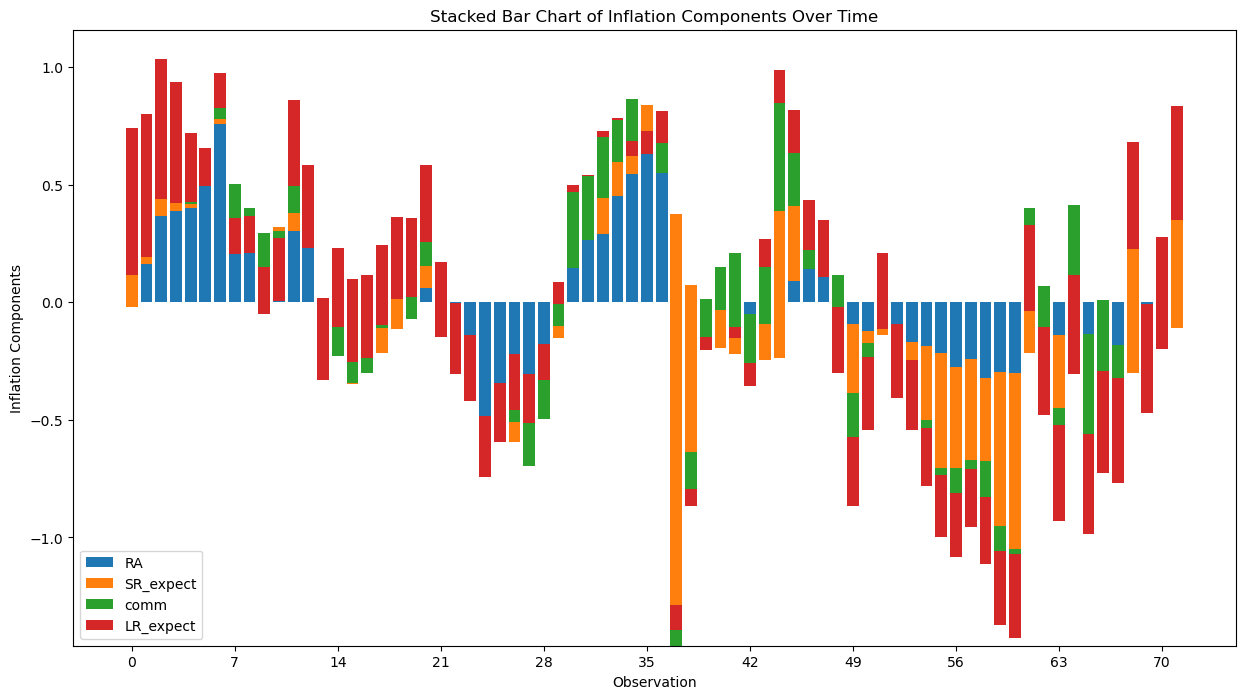

In [38]:
comps = np.vstack((results['part_pred_in_mean'], results['part_pred_mean']))

observations = len(comps)

components_names = ['RA', 'SR_expect', 'comm', 'LR_expect']

# Creating the stacked bar chart
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Stacking bars for each component
bottom = np.zeros(observations)
for i in range(4):
    plt.bar(range(observations), comps[:, i], bottom=bottom, label=components_names[i])
    bottom += comps[:, i]

plt.xlabel('Observation')
plt.ylabel('Inflation Components')
plt.title('Stacked Bar Chart of Inflation Components Over Time')
plt.xticks(range(0, observations, max(1, observations // 10)))  # Adjust the x-axis ticks as needed
plt.legend()

plt.show()

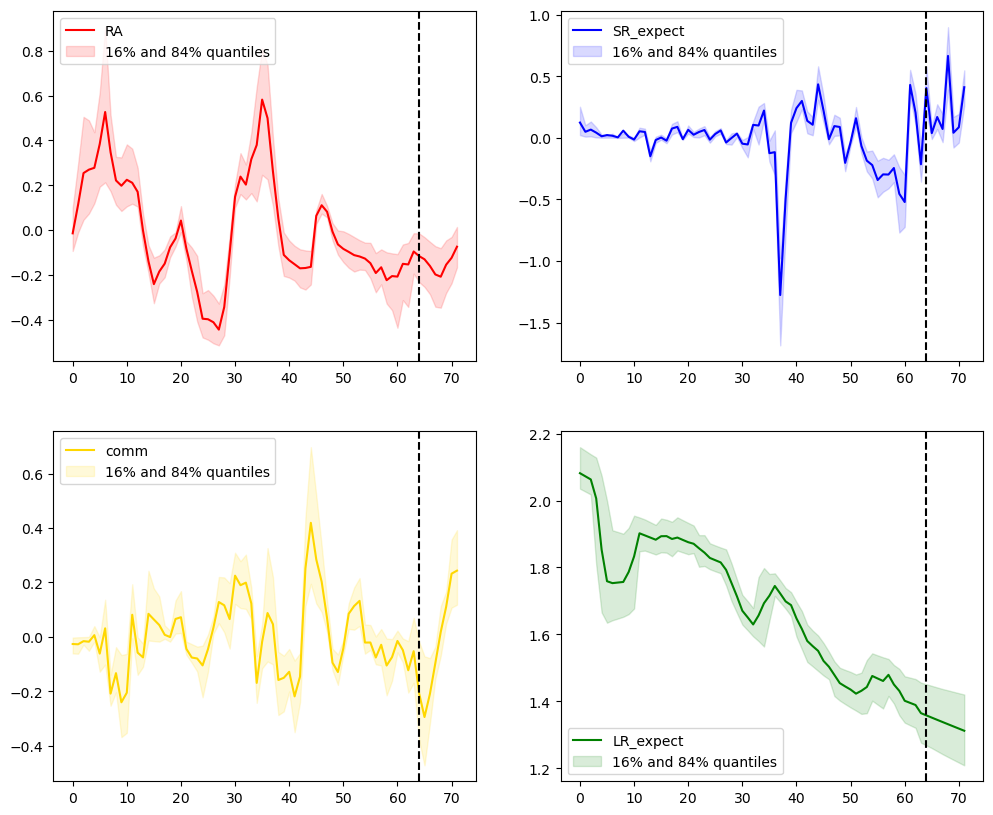

In [39]:
# Get all components
RA = np.concatenate((results['part_pred_in_mean'][:,0], results['part_pred_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,0,:],results["part_pred_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400


SR_expect = np.concatenate((results['part_pred_in_mean'][:,1], results['part_pred_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,1,:],results["part_pred_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['part_pred_in_mean'][:,2], results['part_pred_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,2,:],results["part_pred_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

### Gaps

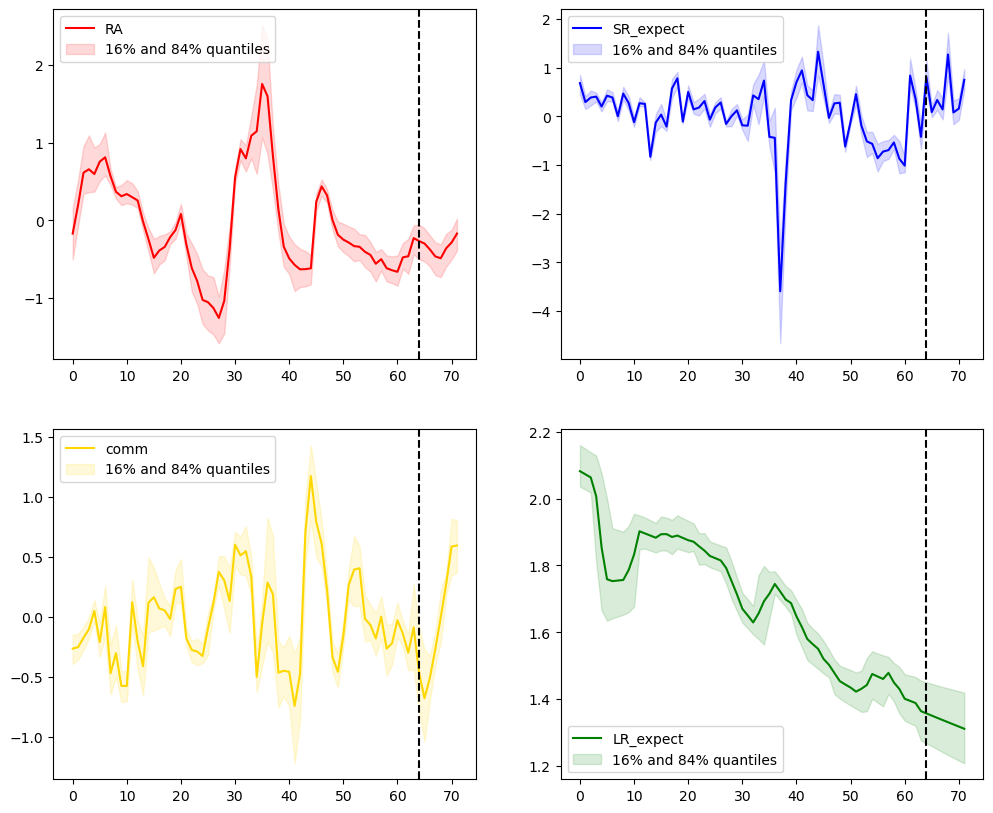

In [40]:
# Get all gaps
RA = np.concatenate((results['gaps_in_mean'][:,0], results['gaps_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["gaps_in_ensemble"][:,0,:],results["gaps_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400

SR_expect = np.concatenate((results['gaps_in_mean'][:,1], results['gaps_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,1,:],results["gaps_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['gaps_in_mean'][:,2], results['gaps_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["gaps_in_ensemble"][:,2,:],results["gaps_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['gaps_in_mean'][:,3], results['gaps_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,3,:],results["gaps_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

## Trends (Time-varying coefficients)

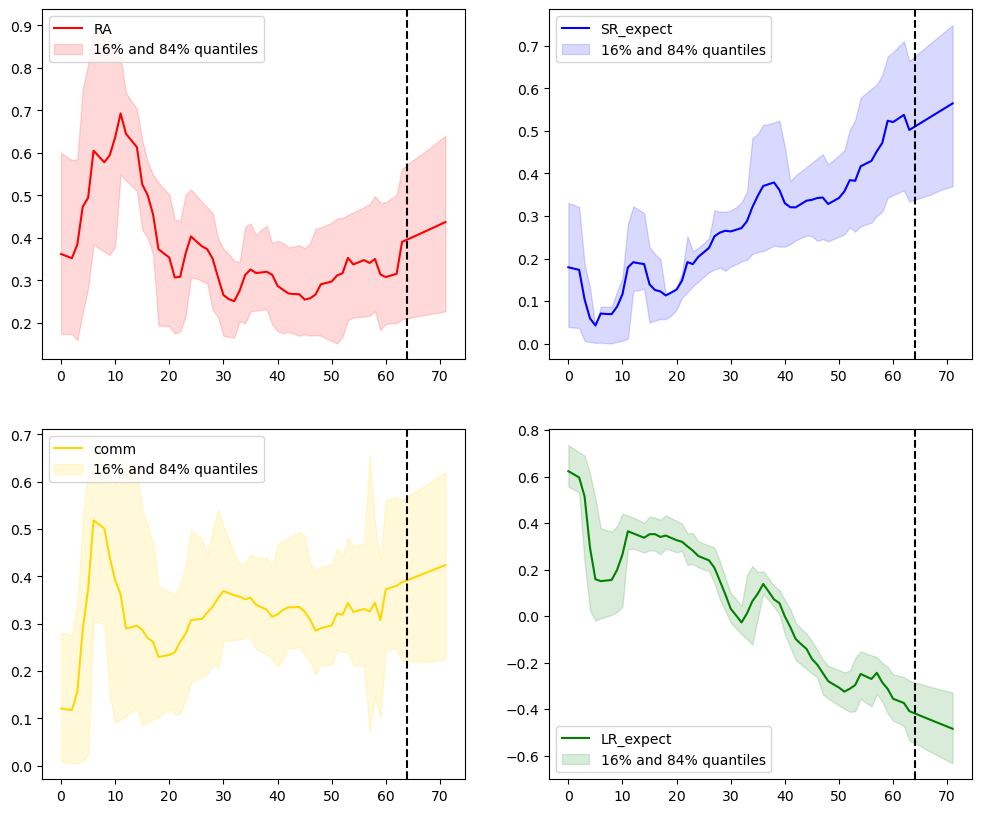

In [41]:
RA = np.concatenate((results['trends_in_mean'][:,0], results['trends_mean'][:,0]), axis=0)
RA_quantiles =  np.concatenate((results["trends_in_ensemble"][:,0,:],results["trends_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)

SR_expect = np.concatenate((results['trends_in_mean'][:,1], results['trends_mean'][:,1]), axis=0)
SR_expect_quantiles = np.concatenate((results["trends_in_ensemble"][:,1,:],results["trends_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)

comm = np.concatenate((results['trends_in_mean'][:,2], results['trends_mean'][:,2]), axis=0)
comm_quantiles = np.concatenate((results["trends_in_ensemble"][:,2,:],results["trends_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

In [42]:
# save model
torch.save(results, '../models/HNN1.pt')